In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install torch numpy
%pip install matplotlib
%pip install seaborn

In [16]:
import pandas as pd

# Cargar dataset local completo
archivo_local = "wine.csv"  # Asegúrate que el archivo esté en la misma carpeta
df = pd.read_csv(archivo_local, sep=';', quotechar='"')

# Asegurarse que los nombres de columnas estén limpios
df.columns = df.columns.str.strip()
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# Mostrar info básica para verificar
print("Primeras filas del dataset:")
print(df.head())

print("\nTipos de datos:")
print(df.dtypes)



Primeras filas del dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4      5.0  
1      9.8    

# 3. Aprendizaje No Supervisado
## 3.1 Dataset y preprocesado

In [19]:

import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import zscore


# Eliminar variable objetivo
X = df.drop('alcohol', axis=1)

print("Valores nulos por columna antes de limpiar:")
print(df.isnull().sum())

# Verificar
print("Forma del dataset sin variable objetivo:", X.shape)
print("Columnas:", X.columns.tolist())

Valores nulos por columna antes de limpiar:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Forma del dataset sin variable objetivo: (6497, 11)
Columnas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'quality']


### Definimos funciones de Preprocesamiento

In [20]:
def normalizar_datos(X):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

def reducir_dimensiones(X, n_componentes=2):
    pca = PCA(n_components=n_componentes)
    return pd.DataFrame(pca.fit_transform(X), columns=[f'PC{i+1}' for i in range(n_componentes)])

def eliminar_outliers(X):
    z_scores = np.abs(zscore(X))
    umbral = 2.0
    mascara = (z_scores < umbral).all(axis=1)
    return X[mascara].reset_index(drop=True)

def balancear_datos(X):
    kmeans = KMeans(n_clusters=7, random_state=42)  
    etiquetas = kmeans.fit_predict(X)
    conteo = np.bincount(etiquetas)
    tamano_min = conteo[conteo > 0].min()  
    X_balanceado = pd.DataFrame()
    for etiqueta in np.unique(etiquetas):
        idx = np.where(etiquetas == etiqueta)[0]
        if len(idx) >= tamano_min:
            indices_muestreados = np.random.choice(idx, size=tamano_min, replace=False)
            X_balanceado = pd.concat([X_balanceado, X.iloc[indices_muestreados]], axis=0)
    return X_balanceado.reset_index(drop=True)

### Generamos las Ocho Versiones del Dataset 
Creamos las ocho configuraciones según la Figura 2, aplicando las combinaciones de preprocesamiento.

In [21]:
datasets = {}
nombres_config = [
    "CC(SI)_ED(NO)_Outliers(NO)_Balanceo(NO)",
    "CC(SI)_ED(NO)_Outliers(NO)_Balanceo(SI)",
    "CC(SI)_ED(NO)_Outliers(SI)_Balanceo(NO)",
    "CC(SI)_ED(NO)_Outliers(SI)_Balanceo(SI)",
    "CC(SI)_ED(SI)_Outliers(NO)_Balanceo(NO)",
    "CC(SI)_ED(SI)_Outliers(NO)_Balanceo(SI)",
    "CC(SI)_ED(SI)_Outliers(SI)_Balanceo(NO)",
    "CC(SI)_ED(SI)_Outliers(SI)_Balanceo(SI)"
]

for config in nombres_config:
    X_temp = X.copy()
    
    # Normalización (siempre SÍ)
    X_temp = normalizar_datos(X_temp)
    
    # Reducción de dimensionalidad
    if "ED(SI)" in config:
        X_temp = reducir_dimensiones(X_temp)
    
    # Eliminación de outliers
    if "Outliers(SI)" in config:
        X_temp = eliminar_outliers(X_temp)
    
    # Balanceo
    if "Balanceo(SI)" in config:
        X_temp = balancear_datos(X_temp)
    
    datasets[config] = X_temp
    print(f"Forma del dataset {config}: {X_temp.shape}")

Forma del dataset CC(SI)_ED(NO)_Outliers(NO)_Balanceo(NO): (6497, 11)
Forma del dataset CC(SI)_ED(NO)_Outliers(NO)_Balanceo(SI): (4333, 11)
Forma del dataset CC(SI)_ED(NO)_Outliers(SI)_Balanceo(NO): (4280, 11)
Forma del dataset CC(SI)_ED(NO)_Outliers(SI)_Balanceo(SI): (3157, 11)
Forma del dataset CC(SI)_ED(SI)_Outliers(NO)_Balanceo(NO): (6497, 2)
Forma del dataset CC(SI)_ED(SI)_Outliers(NO)_Balanceo(SI): (1785, 2)
Forma del dataset CC(SI)_ED(SI)_Outliers(SI)_Balanceo(NO): (6098, 2)
Forma del dataset CC(SI)_ED(SI)_Outliers(SI)_Balanceo(SI): (3941, 2)


## 3.2 Entrenamiento con K-Means y DBSCAN

Entrenamos K-Means para cada dataset, determinando el número óptimo de clústeres con el método del codo y la puntuación de silhouette.

In [22]:
def evaluar_kmeans(X, max_k=10):
    inercias = []
    silhouettes = []
    K = range(2, max_k + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inercias.append(kmeans.inertia_)
        if len(np.unique(kmeans.labels_)) > 1:
            silhouettes.append(silhouette_score(X, kmeans.labels_))
        else:
            silhouettes.append(-1)
    # Seleccionar k óptimo
    k_optimo = K[np.argmax(silhouettes)]
    return k_optimo

# Entrenar K-Means
resultados_kmeans = {}
for config, X_temp in datasets.items():
    print(f"\nEntrenando K-Means para {config}")
    k_optimo = evaluar_kmeans(X_temp)
    kmeans = KMeans(n_clusters=k_optimo, random_state=42)
    kmeans.fit(X_temp)
    etiquetas = kmeans.labels_
    inercia = kmeans.inertia_
    silhouette = silhouette_score(X_temp, etiquetas) if len(np.unique(etiquetas)) > 1 else -1
    resultados_kmeans[config] = {
        'modelo': kmeans,
        'k_optimo': k_optimo,
        'inercia': inercia,
        'silhouette': silhouette,
        'etiquetas': etiquetas
    }
    print(f"K óptimo: {k_optimo}, Inercia: {inercia:.2f}, Silhouette: {silhouette:.2f}")


Entrenando K-Means para CC(SI)_ED(NO)_Outliers(NO)_Balanceo(NO)
K óptimo: 2, Inercia: 56005.65, Silhouette: 0.28

Entrenando K-Means para CC(SI)_ED(NO)_Outliers(NO)_Balanceo(SI)
K óptimo: 2, Inercia: 39574.75, Silhouette: 0.27

Entrenando K-Means para CC(SI)_ED(NO)_Outliers(SI)_Balanceo(NO)
K óptimo: 3, Inercia: 18534.24, Silhouette: 0.22

Entrenando K-Means para CC(SI)_ED(NO)_Outliers(SI)_Balanceo(SI)
K óptimo: 2, Inercia: 17284.38, Silhouette: 0.25

Entrenando K-Means para CC(SI)_ED(SI)_Outliers(NO)_Balanceo(NO)
K óptimo: 2, Inercia: 18471.96, Silhouette: 0.48

Entrenando K-Means para CC(SI)_ED(SI)_Outliers(NO)_Balanceo(SI)
K óptimo: 2, Inercia: 6255.59, Silhouette: 0.48

Entrenando K-Means para CC(SI)_ED(SI)_Outliers(SI)_Balanceo(NO)
K óptimo: 3, Inercia: 7273.23, Silhouette: 0.48

Entrenando K-Means para CC(SI)_ED(SI)_Outliers(SI)_Balanceo(SI)
K óptimo: 2, Inercia: 8963.19, Silhouette: 0.48


## DBSCAN: Ajuste de MinPts y ε

Ajustamos DBSCAN usando un gráfico de k-distancias para determinar eps y min_samples.

In [23]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


def ajustar_dbscan(X):
    min_pts = 2 * X.shape[1]  
    vecinos = NearestNeighbors(n_neighbors=min_pts)
    vecinos_fit = vecinos.fit(X)
    distancias, _ = vecinos_fit.kneighbors(X)
    distancias = np.sort(distancias[:, min_pts-1], axis=0)
    
    # Probar valores de eps
    eps_valores = np.arange(0.5, 5.0, 0.5)  
    mejor_silhouette = -1
    mejores_params = None
    mejores_etiquetas = None
    
    for eps in eps_valores:
        dbscan = DBSCAN(eps=eps, min_samples=min_pts)
        etiquetas = dbscan.fit_predict(X)
        if len(np.unique(etiquetas)) > 1 and -1 in etiquetas:
            try:
                silhouette = silhouette_score(X[etiquetas != -1], etiquetas[etiquetas != -1])
                if silhouette > mejor_silhouette:
                    mejor_silhouette = silhouette
                    mejores_params = (eps, min_pts)
                    mejores_etiquetas = etiquetas
            except:
                continue
    
    if mejores_params is None:
        print("No se encontraron clústeres válidos para DBSCAN.")
        return (0.5, min_pts), np.zeros(X.shape[0]), -1
    
    return mejores_params, mejores_etiquetas, mejor_silhouette

# Entrenar DBSCAN
resultados_dbscan = {}
for config, X_temp in datasets.items():
    print(f"\nEntrenando DBSCAN para {config}")
    (eps, min_pts), etiquetas, silhouette = ajustar_dbscan(X_temp)
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    dbscan.fit(X_temp)
    resultados_dbscan[config] = {
        'modelo': dbscan,
        'eps': eps,
        'min_pts': min_pts,
        'silhouette': silhouette,
        'etiquetas': etiquetas
    }
    print(f"Eps óptimo: {eps:.2f}, MinPts: {min_pts}, Silhouette: {silhouette:.2f}")


Entrenando DBSCAN para CC(SI)_ED(NO)_Outliers(NO)_Balanceo(NO)
Eps óptimo: 1.00, MinPts: 22, Silhouette: 0.22

Entrenando DBSCAN para CC(SI)_ED(NO)_Outliers(NO)_Balanceo(SI)
Eps óptimo: 1.00, MinPts: 22, Silhouette: 0.51

Entrenando DBSCAN para CC(SI)_ED(NO)_Outliers(SI)_Balanceo(NO)
Eps óptimo: 1.00, MinPts: 22, Silhouette: 0.18

Entrenando DBSCAN para CC(SI)_ED(NO)_Outliers(SI)_Balanceo(SI)
Eps óptimo: 1.00, MinPts: 22, Silhouette: 0.34

Entrenando DBSCAN para CC(SI)_ED(SI)_Outliers(NO)_Balanceo(NO)
Eps óptimo: 0.50, MinPts: 4, Silhouette: 0.51

Entrenando DBSCAN para CC(SI)_ED(SI)_Outliers(NO)_Balanceo(SI)
Eps óptimo: 0.50, MinPts: 4, Silhouette: 0.39

Entrenando DBSCAN para CC(SI)_ED(SI)_Outliers(SI)_Balanceo(NO)
No se encontraron clústeres válidos para DBSCAN.
Eps óptimo: 0.50, MinPts: 4, Silhouette: -1.00

Entrenando DBSCAN para CC(SI)_ED(SI)_Outliers(SI)_Balanceo(SI)
No se encontraron clústeres válidos para DBSCAN.
Eps óptimo: 0.50, MinPts: 4, Silhouette: -1.00


### Generar Tres Casos de Prueba por Técnica

Generamos tres casos de prueba para cada dataset y algoritmo, prediciendo clústeres para puntos muestreados

In [24]:
def generar_casos_prueba(X, modelo, n_muestras=3):
    np.random.seed(42)
    indices = np.random.choice(X.index, size=n_muestras, replace=False)
    muestras_prueba = X.iloc[indices]
    if isinstance(modelo, KMeans):
        predicciones = modelo.predict(muestras_prueba)
    else:  # DBSCAN
        predicciones = modelo.fit_predict(muestras_prueba)
    return muestras_prueba, predicciones

# Generar casos de prueba
for config, X_temp in datasets.items():
    print(f"\nCasos de prueba para {config}")
    
    # K-Means
    modelo_kmeans = resultados_kmeans[config]['modelo']
    muestras, predicciones = generar_casos_prueba(X_temp, modelo_kmeans)
    print("Casos de Prueba K-Means:")
    for i, (muestra, pred) in enumerate(zip(muestras.values, predicciones)):
        print(f"Muestra {i+1}: {muestra.round(2)}, Clúster: {pred}")
    
    # DBSCAN
    modelo_dbscan = resultados_dbscan[config]['modelo']
    muestras, predicciones = generar_casos_prueba(X_temp, modelo_dbscan)
    print("Casos de Prueba DBSCAN:")
    for i, (muestra, pred) in enumerate(zip(muestras.values, predicciones)):
        print(f"Muestra {i+1}: {muestra.round(2)}, Clúster: {pred}")


Casos de prueba para CC(SI)_ED(NO)_Outliers(NO)_Balanceo(NO)
Casos de Prueba K-Means:
Muestra 1: [-0.17 -1.03  2.9   1.55 -0.31 -0.37  0.18 -0.17  0.26 -1.02  2.5 ], Clúster: 1
Muestra 2: [ 0.37  1.82 -0.75 -0.68  0.6   0.08  0.31  0.3   0.32 -0.55 -0.94], Clúster: 0
Muestra 3: [-0.32  0.31  0.15  0.41 -1.03  0.42  0.31 -0.86 -0.24 -0.61  1.35], Clúster: 1
Casos de Prueba DBSCAN:
Muestra 1: [-0.17 -1.03  2.9   1.55 -0.31 -0.37  0.18 -0.17  0.26 -1.02  2.5 ], Clúster: -1
Muestra 2: [ 0.37  1.82 -0.75 -0.68  0.6   0.08  0.31  0.3   0.32 -0.55 -0.94], Clúster: -1
Muestra 3: [-0.32  0.31  0.15  0.41 -1.03  0.42  0.31 -0.86 -0.24 -0.61  1.35], Clúster: -1

Casos de prueba para CC(SI)_ED(NO)_Outliers(NO)_Balanceo(SI)
Casos de Prueba K-Means:
Muestra 1: [-0.63 -1.09 -0.06 -0.03 -0.37  0.65  0.73 -0.05  0.82 -0.41 -0.94], Clúster: 1
Muestra 2: [-0.09 -0.06 -0.95  0.18  1.08 -0.2   0.89  0.01 -1.98 -0.28 -0.94], Clúster: 1
Muestra 3: [-0.63  0.61  0.84  1.88 -0.23 -0.09  1.99  1.62  0.26  0.06

## 3.4 Graficas 2D

### Grafica para los K-Means

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid featu

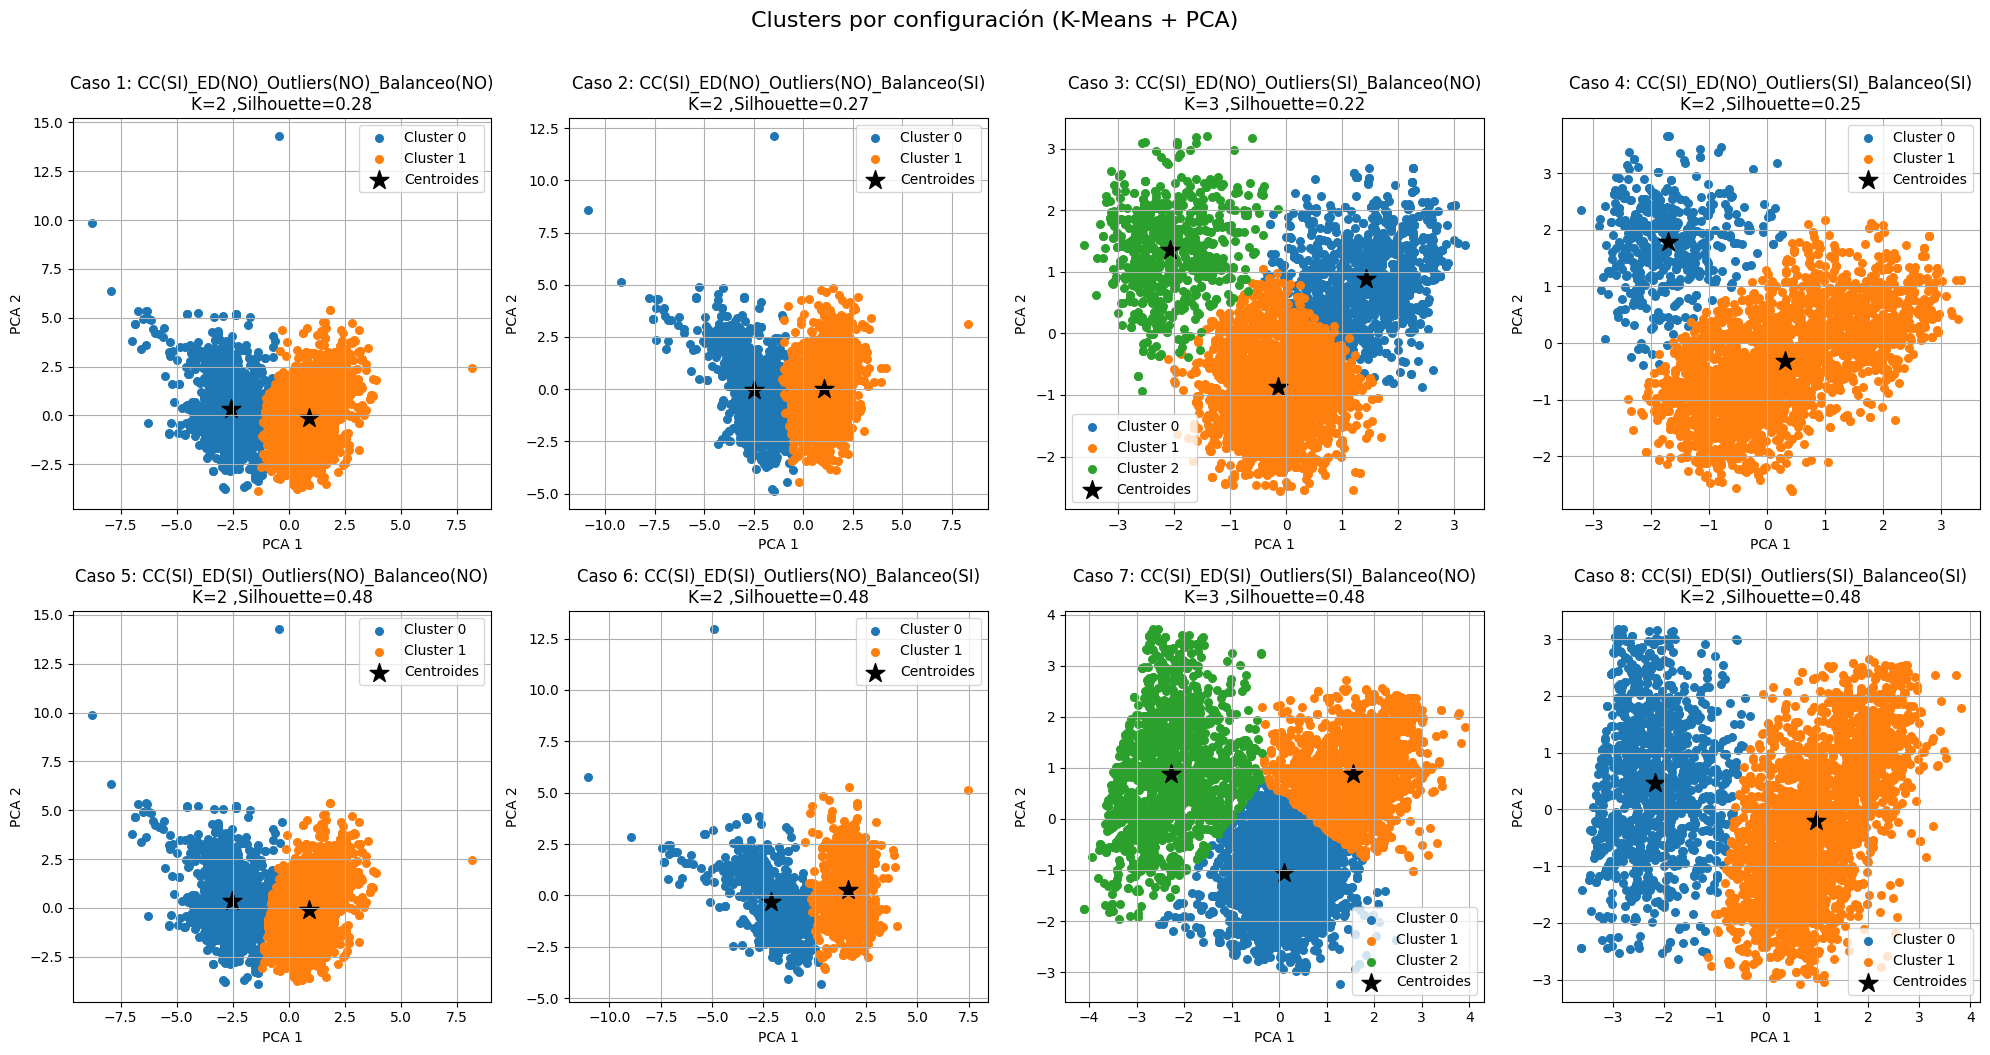

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Crear figura grande con subplots (2 filas x 4 columnas)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Aplanar para iterar fácilmente

# Recorremos los resultados guardados para cada configuración
for idx, (config, resultados) in enumerate(resultados_kmeans.items()):
    kmeans = resultados['modelo']
    X_temp = datasets[config]
    etiquetas = resultados['etiquetas']
    k_optimo = resultados['k_optimo']

    # Aplicar PCA a los datos para reducir a 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_temp)

    # Proyectar los centroides al mismo espacio PCA
    centroides_pca = pca.transform(kmeans.cluster_centers_)

    # Graficar en el subplot correspondiente
    ax = axes[idx]
    for cluster_id in range(k_optimo):
        puntos_cluster = X_pca[etiquetas == cluster_id]
        ax.scatter(puntos_cluster[:, 0], puntos_cluster[:, 1], label=f'Cluster {cluster_id}', s=30)

    ax.scatter(centroides_pca[:, 0], centroides_pca[:, 1],
               s=200, c='black', marker='*', label='Centroides')

    ax.set_title(f'Caso {idx + 1}: {config}\nK={k_optimo} ,Silhouette={resultados["silhouette"]:.2f}')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.legend()
    ax.grid(True)

# Ajustar diseño general
plt.tight_layout()
plt.suptitle('Clusters por configuración (K-Means + PCA)', fontsize=16, y=1.05)
plt.show()


### Grafica para DBSCAN

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14248\3399650446.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


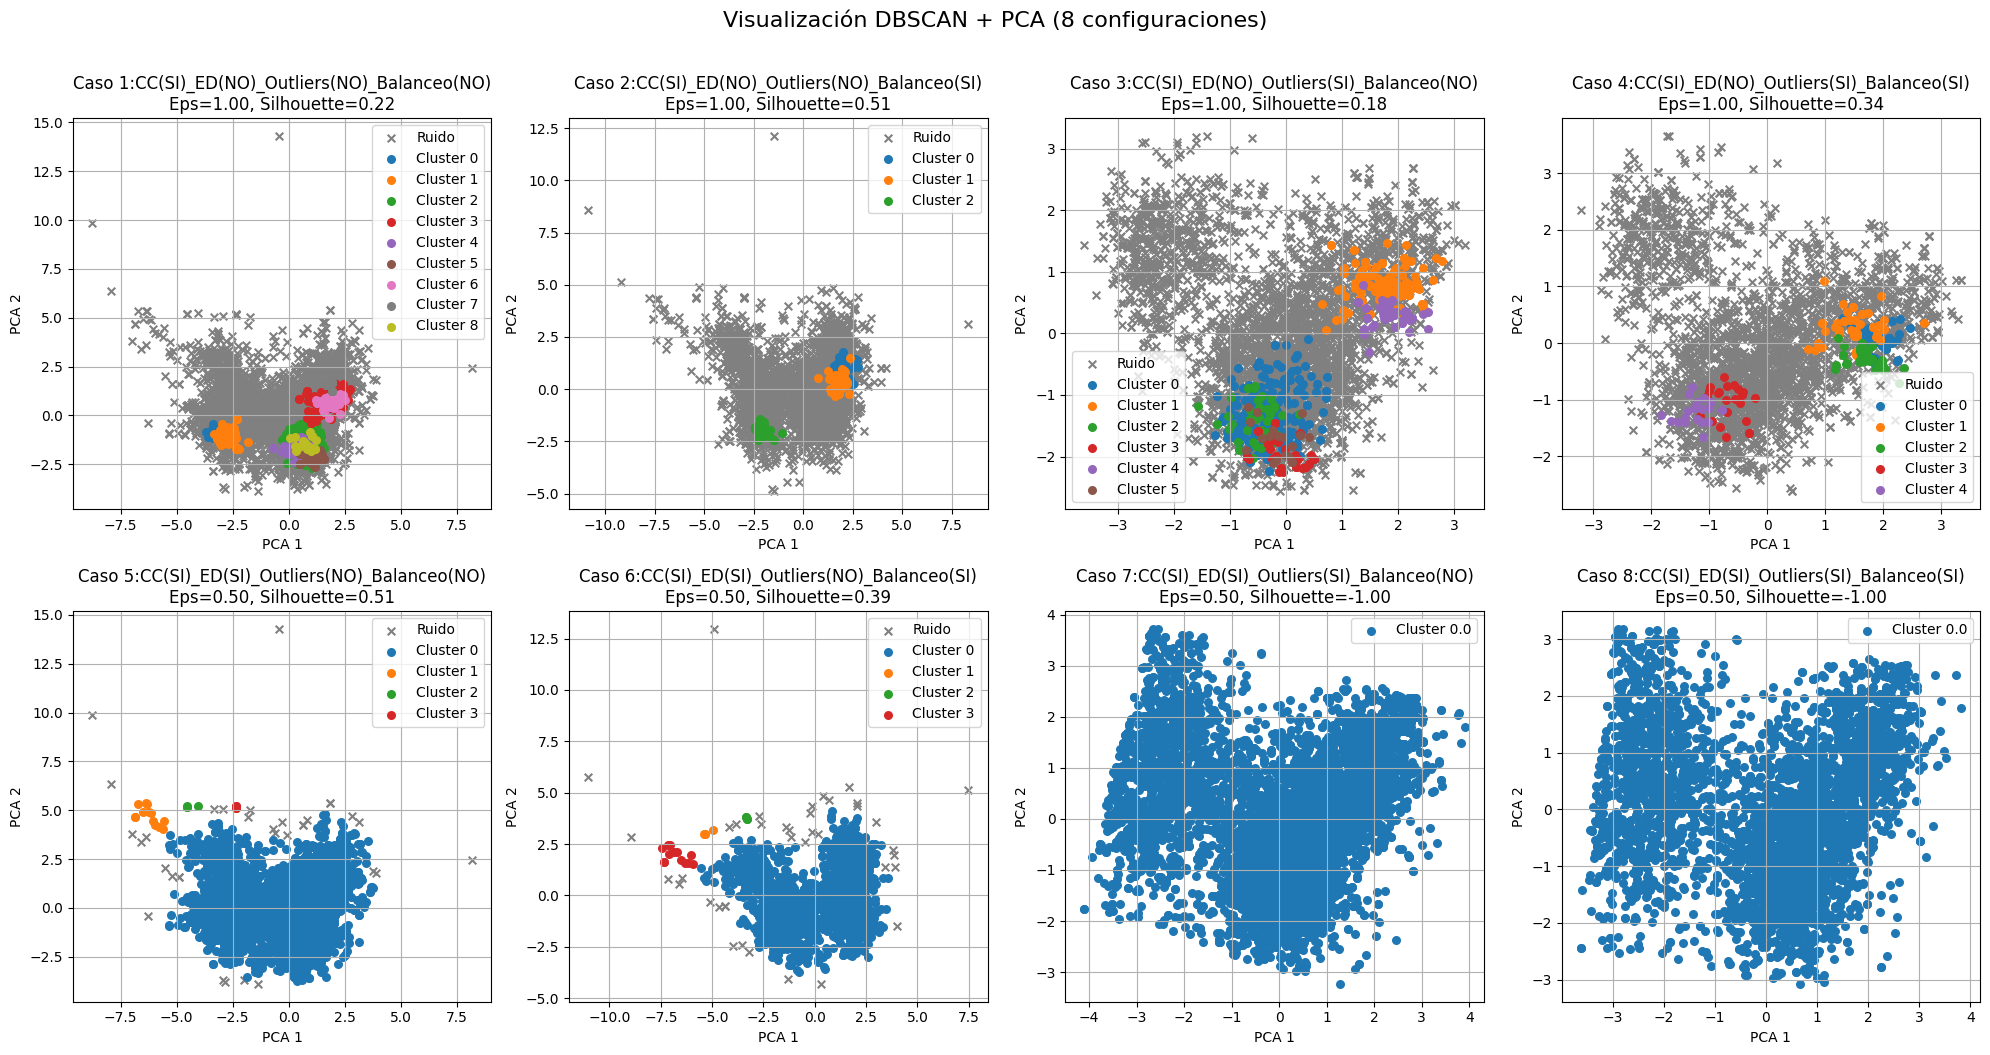

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Crear figura con 8 subgráficos (2 filas, 4 columnas)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Paleta de colores para clusters (excluyendo el ruido)
from matplotlib import cm
cmap = cm.get_cmap('tab10')

for idx, (config, resultados) in enumerate(resultados_dbscan.items()):
    etiquetas = resultados['etiquetas']
    X_temp = datasets[config]

    # Aplicar PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_temp)

    # Graficar clusters
    ax = axes[idx]
    etiquetas_unicas = np.unique(etiquetas)

    for etiqueta in etiquetas_unicas:
        puntos = X_pca[etiquetas == etiqueta]
        if etiqueta == -1:
            # Ruido: color gris
            ax.scatter(puntos[:, 0], puntos[:, 1], c='gray', label='Ruido', s=30, marker='x')
        else:
            color = cmap(etiqueta % 10)  # Rotar colores si hay más de 10 clusters
            ax.scatter(puntos[:, 0], puntos[:, 1], c=[color], label=f'Cluster {etiqueta}', s=30)

    ax.set_title(f'Caso {idx + 1}:{config}\nEps={resultados["eps"]:.2f}, Silhouette={resultados["silhouette"]:.2f}')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.legend()
    ax.grid(True)

# Ajustar espacios entre subgráficos
plt.tight_layout()
plt.suptitle('Visualización DBSCAN + PCA (8 configuraciones)', fontsize=16, y=1.05)
plt.show()
